Details of the Dataset:
Project Type: Semantic Segmentation

Subject: Tumor

Classes:

Tumor (Class 1)
Non-Tumor (Class 0)
Key Information:

Last Updated: 9 months ago
Overview of the Project:
The TumorSeg Computer Vision Project is dedicated to Semantic Segmentation, which involves classifying every pixel in an image as part of a tumor or non-tumor region. This fine-grained approach provides an accurate understanding of the spatial distribution of tumors within medical images.

Classes:
This dataset is divided into two classes:
**Class 0 (Non-Tumor):

Pixels labeled as non-tumor represent areas without any tumor presence in the medical images.
**Class 1 (Tumor):
Pixels labeled as tumors correspond to areas where tumors are detected.
Usage of the Dataset:
Researchers and practitioners in the field of medical image analysis can use this dataset to train and evaluate semantic segmentation models for tumor detection. The binary classification into tumor and non-tumor classes simplifies the segmentation task, making it suitable for various applications.


### 📦 Library Imports


In [65]:
import os 
import glob
import json
import numpy as np
import cv2

from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D,Flatten,Dropout,BatchNormalization,Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint

⚙️ GPU Configuration


In [66]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

📁 Dataset Path Configuration

In [69]:
train_path  = "C:/Users/er_po/Desktop/Dataguess/ImageSegmantation/data/train/"
test_path = "C:/Users/er_po/Desktop/Dataguess/ImageSegmantation/data/test/"
valid_path  = "C:/Users/er_po/Desktop/Dataguess/ImageSegmantation/data/valid/"

📸 Load Image Filenames

In [70]:
train_data=[image for image in os.listdir(train_path)]
test_data=[image for image in os.listdir(test_path)]
valid_data=[image for image in os.listdir(valid_path)]

### 📂 Load Annotation Files (JSON)

In [72]:
train_annotation=json.load(open(train_annotation[0]))
test_annotation=json.load(open(test_annotation[0]))
valid_annotation=json.load(open(valid_annotation[0]))

🔍 Visualize Random Images with Annotations

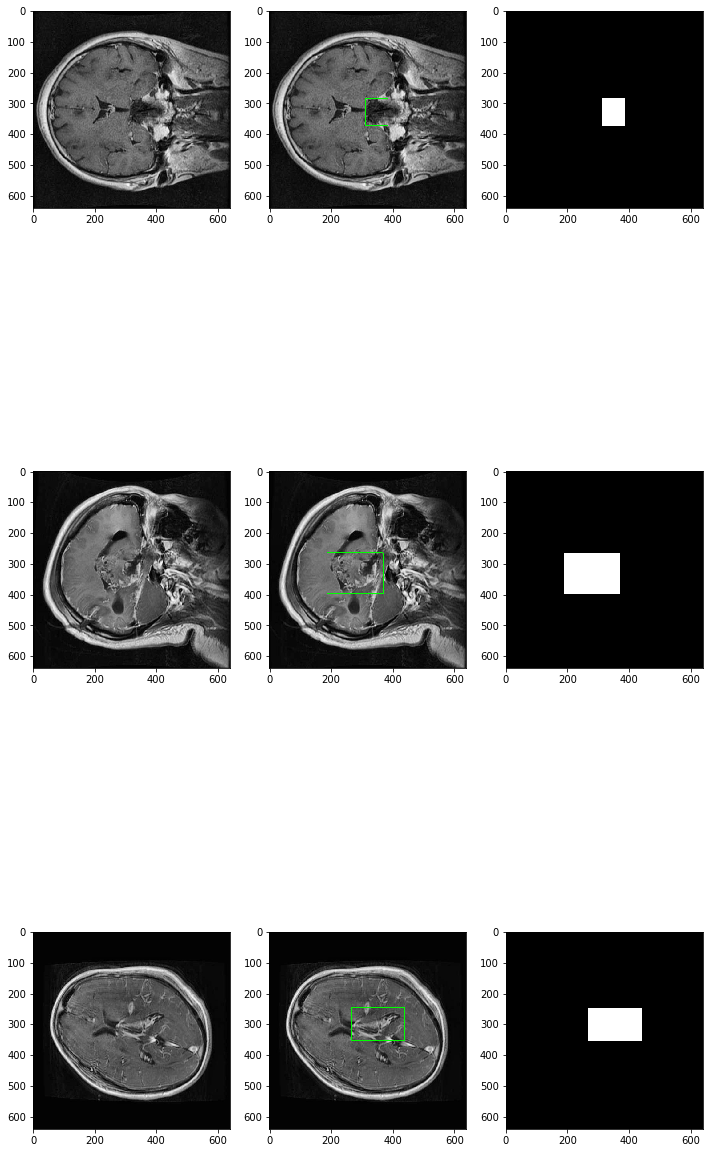

In [73]:
import matplotlib.pyplot as plt

def visualize_random_images(n=3): # select n random images

  # use cv and plt to show these images
  indices = np.random.randint(0, len(train_annotation['images']), size=n)

    #Image and Annotation Retrieval:
  images =[train_annotation['images'][i] for i in indices ]
  annotations = [train_annotation['annotations'][i] for i in indices ]
    
  j=1
  plt.figure(figsize=(12, 4 * 2 * n))
  for img,ann in zip(images,annotations):
    
    plt.subplot(n,3,j)
    j+=1
    image = cv2.imread(train_path + img['file_name'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    
    # create masked images from annotations
    segmentation = ann['segmentation']
    segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2) #convert 1D into 2D

    cv2.polylines(image, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)  # Green color with thickness 2

    plt.subplot(n,3,j)
    plt.imshow(image)
    j+=1
    
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    cv2.fillPoly(mask, [segmentation], color=1)
    plt.subplot(n,3,j)
    plt.imshow(mask,cmap='gray')
    j+=1

visualize_random_images()


# Apply Mask for all Image

In [75]:
def _train_masks():
    print('train masks')
    mask_dir = 'C:/Users/er_po/Desktop/Dataguess/ImageSegmantation/working/train_masks/'
    os.makedirs(mask_dir, exist_ok=True)
    totalImages = len(train_annotation['images'])
    done = 0
    for img,ann in zip(train_annotation['images'],train_annotation['annotations']):
        path = train_path + img['file_name']
        mask_path = mask_dir + img['file_name']
        # load image in open cv
        image = cv2.imread(path)
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=(255,255,255))
        cv2.imwrite(mask_path, mask)
        done+=1
        print(f"train  {done} / {totalImages} ")

def _test_masks():
    print('test masks')

    totalImages = len(test_annotation['images'])
    done = 0
    mask_dir = 'C:/Users/er_po/Desktop/Dataguess/ImageSegmantation/working/test_masks/'
    os.makedirs(mask_dir, exist_ok=True)
    
    for img,ann in zip(test_annotation['images'],test_annotation['annotations']):
        path = test_path + img['file_name']
        mask_path = mask_dir + img['file_name']
        # load image in open cv
        image = cv2.imread(path)
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=(255,255,255))
        cv2.imwrite(mask_path, mask)
        done+=1

        print(f"test  {done} / {totalImages} ")


def _val_masks():
    print('val masks')
    totalImages = len(valid_annotation['images'])
    done = 0
    mask_dir = 'C:/Users/er_po/Desktop/Dataguess/ImageSegmantation/working/val_masks/'
    os.makedirs(mask_dir, exist_ok=True)
    
    for img,ann in zip(valid_annotation['images'],valid_annotation['annotations']):
        path = valid_path + img['file_name']
        mask_path = mask_dir + img['file_name']
        # load image in open cv
        image = cv2.imread(path)
        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=(255,255,255))
        cv2.imwrite(mask_path, mask)
        done+=1
        print(f"val  {done} / {totalImages} ")


from threading import Thread
def make_masks():
  threads = []
  threads.append( Thread(target=_train_masks))

  threads.append( Thread(target=_test_masks))

  threads.append( Thread(target=_val_masks))
  for t in threads:
    t.start()
  for t in threads:
    t.join()
  print('complete')
  return

make_masks()

train masks
test masks
val masks
train  1 / 1502 
test  1 / 215 
val  1 / 429 
train  2 / 1502 val  2 / 429 

test  2 / 215 
test  3 / 215 val  3 / 429 

train  3 / 1502 
val  4 / 429 
test  4 / 215 
train  4 / 1502 
val  5 / 429 
test  5 / 215 
train  5 / 1502 
val  6 / 429 
test  6 / 215 
train  6 / 1502 
val  7 / 429 test  7 / 215 

train  7 / 1502 val  8 / 429 

test  8 / 215 
val  9 / 429 train  8 / 1502 

test  9 / 215 
train  9 / 1502 val  10 / 429 
test  10 / 215 

val  11 / 429 
test  11 / 215 
train  10 / 1502 
test  12 / 215 val  12 / 429 

train  11 / 1502 
test  13 / 215 val  13 / 429 

train  12 / 1502 
test  14 / 215 
val  14 / 429 
train  13 / 1502 
test  15 / 215 
val  15 / 429 
test  16 / 215 
val  16 / 429 
train  14 / 1502 
val  17 / 429 test  17 / 215 

train  15 / 1502 
test  18 / 215 
val  18 / 429 
train  16 / 1502 
val  19 / 429 
test  19 / 215 
val  20 / 429 train  17 / 1502 

test  20 / 215 
train  18 / 1502 
val  21 / 429 
test  21 / 215 train  19 / 1502 

v

# Split Data

In [ ]:
def load_data():
    target_size = (128, 128)
    train_mask_dir = 'C:/Users/er_po/Desktop/Dataguess/ImageSegmantation/working/train_masks/'
    
    X_train =  [cv2.resize(cv2.imread(train_path + image['file_name']),target_size) for image in train_annotation['images']]
    y_train = [cv2.resize(cv2.imread(train_mask_dir + image['file_name'],cv2.IMREAD_GRAYSCALE),target_size ) for image in train_annotation['images']]
    X_train = np.array(X_train)
    y_train = np.expand_dims(np.array(y_train), axis=-1)
    
    X_train = X_train.astype('float32') / 255.0
    y_train = y_train.astype('float32') / 255.0
    y_train = (y_train > 0.5).astype(np.float32)
    
    val_mask_dir = 'C:/Users/er_po/Desktop/Dataguess/ImageSegmantation/working/val_masks/'
    X_val =  [cv2.resize(cv2.imread(valid_path + image['file_name']),target_size) for image in valid_annotation['images']]
    y_val = [cv2.resize(cv2.imread(val_mask_dir + image['file_name'],cv2.IMREAD_GRAYSCALE),target_size) for image in valid_annotation['images']]
    X_val = np.array(X_val)
    y_val = np.expand_dims(np.array(y_val), axis=-1)

    X_val = X_val.astype('float32') / 255.0
    y_val = y_val.astype('float32') / 255.0
    y_val = (y_val > 0.5).astype(np.float32)
    
    return X_train,y_train,X_val,y_val


def load_test_data():
    target_size = (128, 128)

    test_mask_dir = 'C:/Users/er_po/Desktop/Dataguess/ImageSegmantation/working/test_masks/'
    X_test =  [cv2.resize(cv2.imread(test_path + image['file_name']),target_size) for image in test_annotation['images']]
    y_test = [cv2.resize(cv2.imread(test_mask_dir + image['file_name'],cv2.IMREAD_GRAYSCALE),target_size) for image in test_annotation['images']]
    X_test = np.array(X_test)
    y_test = np.expand_dims(np.array(y_test), axis=-1)

        
    X_test = X_test.astype('float32') / 255.0
    y_test = y_test.astype('float32') / 255.0
    y_test = (y_test > 0.5).astype(np.float32)
    return X_test,y_test

In [77]:
X_train,y_train,X_val,y_val = load_data()


🧠 U-Net Building Blocks (Functional API)

🔹 Double Convolution Block

In [78]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

🔻 Downsampling Block

In [79]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

🔺 Upsampling Block

In [80]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

### 🏗️ Build the U-Net Model


In [81]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [82]:
unet_model = build_unet_model()


⚙️ Compile the Model

In [83]:
unet_model.compile(optimizer="adam",loss="BinaryCrossentropy",metrics=["accuracy"])


📊 Model Summary

In [84]:
unet_model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 128, 128, 64  1792        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_153 (Conv2D)            (None, 128, 128, 64  36928       ['conv2d_152[0][0]']             
                                )                                                             

🏋️ Train the Model

In [85]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss',patience=5)
                            
callbacks_list = [earlystop]

unet_model.fit(X_train,y_train,epochs=50,validation_data=(X_val,y_val),callbacks=callbacks_list)

Epoch 1/50
47/47 [==============================] - 679s 14s/step - loss: 0.3502 - accuracy: 0.9534 - val_loss: 0.1345 - val_accuracy: 0.9627
Epoch 2/50
47/47 [==============================] - 589s 12s/step - loss: 0.1181 - accuracy: 0.9628 - val_loss: 0.1122 - val_accuracy: 0.9627
Epoch 3/50
47/47 [==============================] - 494s 11s/step - loss: 0.1094 - accuracy: 0.9628 - val_loss: 0.1132 - val_accuracy: 0.9627
Epoch 4/50
47/47 [==============================] - 461s 10s/step - loss: 0.1074 - accuracy: 0.9628 - val_loss: 0.1060 - val_accuracy: 0.9627
Epoch 5/50
47/47 [==============================] - 468s 10s/step - loss: 0.1060 - accuracy: 0.9628 - val_loss: 0.1026 - val_accuracy: 0.9627
Epoch 6/50
47/47 [==============================] - 518s 11s/step - loss: 0.1028 - accuracy: 0.9628 - val_loss: 0.0979 - val_accuracy: 0.9627
Epoch 7/50
47/47 [==============================] - 493s 11s/step - loss: 0.1054 - accuracy: 0.9628 - val_loss: 0.1157 - val_accuracy: 0.9627
Epoch 

🔍 Make Predictions with Thresholding

In [ ]:
def predict(image_path, model, threshold=0.5):
    
    image = cv2.imread(image_path)
    print("Original Image Shape:", image.shape)
    
    resized_image = cv2.resize(image, (128, 128))
    print("Resized Image Shape:", resized_image.shape)
    
    input_image = np.expand_dims(resized_image, axis=0)
    
    input_image = input_image.astype('float32') / 255.0
    
    pred_mask = model.predict(input_image)
    
    pred_mask[pred_mask >= threshold] = 1  
    pred_mask[pred_mask < threshold] = 0  
    
    pred_mask = np.squeeze(pred_mask, axis=0)
    
    num_pixels = np.count_nonzero(pred_mask)
    print("shape mask",pred_mask.shape)
    return pred_mask

🧪 Visualize Test Results

Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 [==============================] - 0s 230ms/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 [==============================] - 0s 239ms/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 [==============================] - 0s 205ms/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 [==============================] - 0s 257ms/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 [==============================] - 0s 281ms/step
shape mask (128, 128, 1)


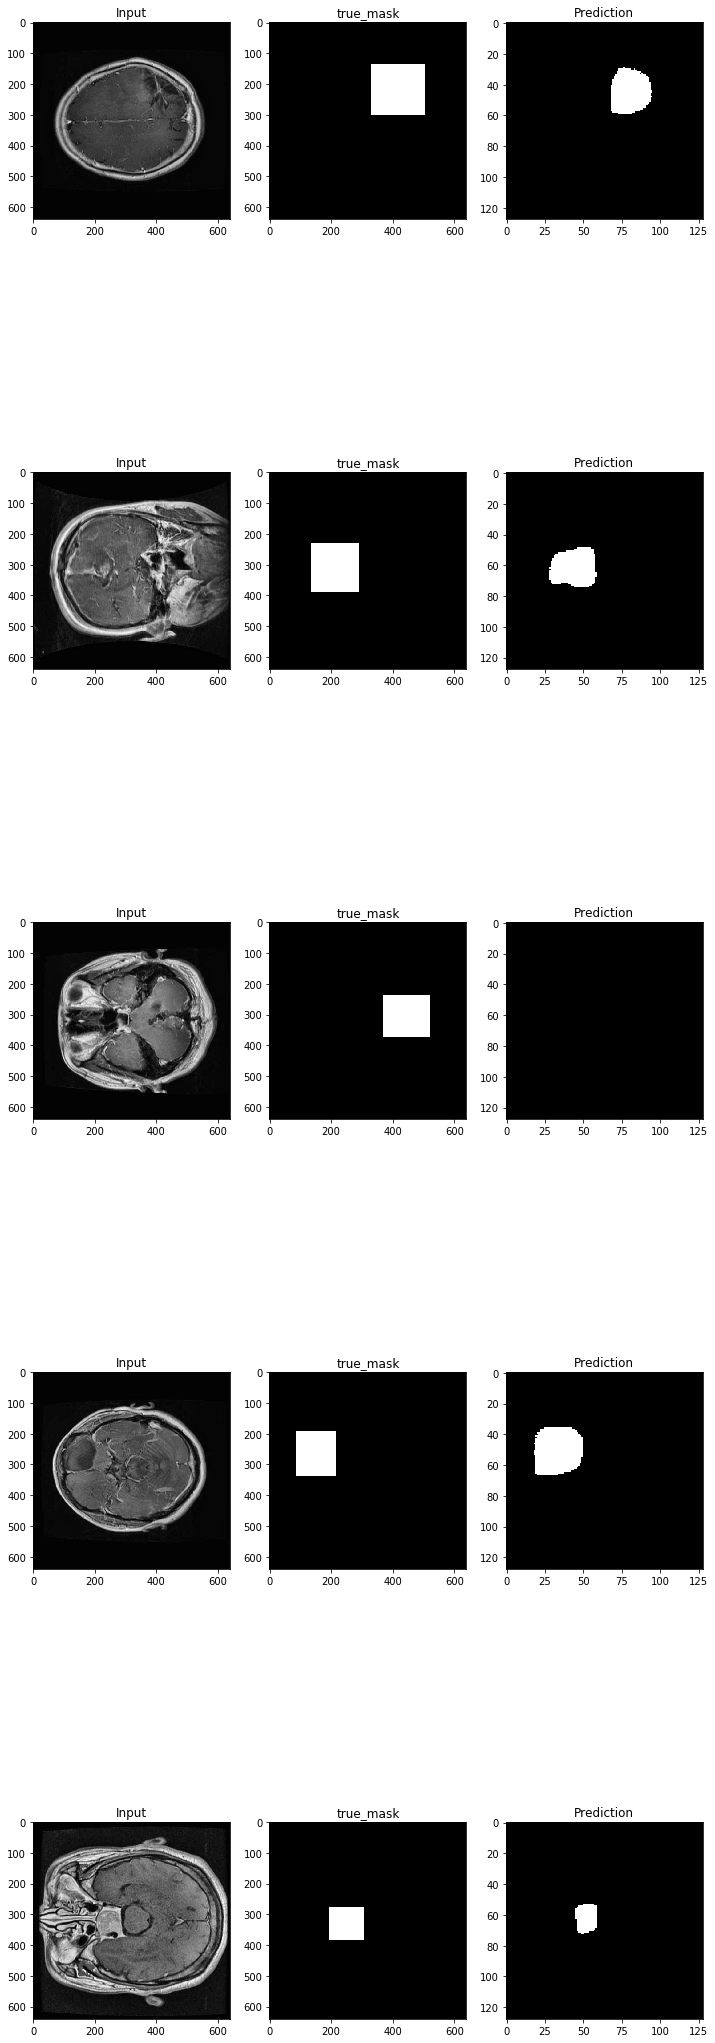

In [ ]:
import matplotlib.pyplot as plt
def test_random_images(n=5):

    test_mask_dir = 'C:/Users/er_po/Desktop/Dataguess/ImageSegmantation/working/test_masks/'

    indices = np.random.randint(0, len(test_annotation['images']), size=n)

    images =[test_annotation['images'][i] for i in indices ]

    annotations = [test_annotation['annotations'][i] for i in indices ]
    j=1
    plt.figure(figsize=(12, 4 * 2 * n))
    for img,ann in zip(images,annotations):
        plt.subplot(n,3,j)
        j+=1
        image = cv2.imread(test_path + img['file_name'])
        
        plt.imshow(image)
        plt.title("Input")
        mask = predict(test_path + img['file_name'],unet_model)
        
        result_image = np.zeros((128, 128,1), dtype=np.uint8)
        result_image[mask == 1] = 255
        
        true_mask = cv2.imread(test_mask_dir + img['file_name'])
        plt.subplot(n,3,j)
        j+=1
        plt.imshow(true_mask)
        plt.title("true_mask")
        
        plt.subplot(n,3,j)
        j+=1
        plt.imshow(result_image.squeeze(),cmap='gray')
        plt.title("Prediction")

test_random_images()